### After running ocetrac, this code saves the event labels as nc files [refer to this](https://github.com/ocetrac/marine-heatwaves/blob/main/code/run_ocetrac.ipynb)

### Load libraries

In [1]:
import dask

import pandas as pd
import netCDF4

import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da
import ocetrac


import warnings
warnings.filterwarnings('ignore')
from datetime import date

import matplotlib.pyplot as plt

print('loaded libraries')


KeyboardInterrupt



### Load in data

In [ ]:
dir_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/"

In [ ]:
ds = xr.open_dataset(f"{dir_path}/data/ocean_daily_cmip.01860101-01901231.tos.nc", chunks={'time':100})

In [ ]:
mt_path = "/pub/mariant3/VeryWarmWaterMasses/02_ocetrac"

In [7]:
static = xr.open_dataset(f"{dir_path}/data/ocean_daily_cmip.static.nc")

In [11]:
blobs = xr.load_dataarray(f"{mt_path}/blobs_0186-04-22_0186-12-08.nc", chunks={'time':100})

#### Define 'ds_region' from 'ds' to only select the region's time and coordinates of interest

In [ ]:
ds_region = ds.sel(xh = slice(-138, 0), yh = slice(8, 49)).isel(time=slice(111,341))

In [ ]:
ds_region

In [8]:
static_region = static.sel(xh = slice(-138, 0), yh = slice(8, 49))

In [ ]:
ds_static_region = xr.merge([static_region,ds_region]) # merge ds and static together

In [10]:
#new_static = static['areacello'].sel(xh = slice(-138, 0), xh = slice(8, 49))

In [ ]:
blobs

(8.0, 16.0)

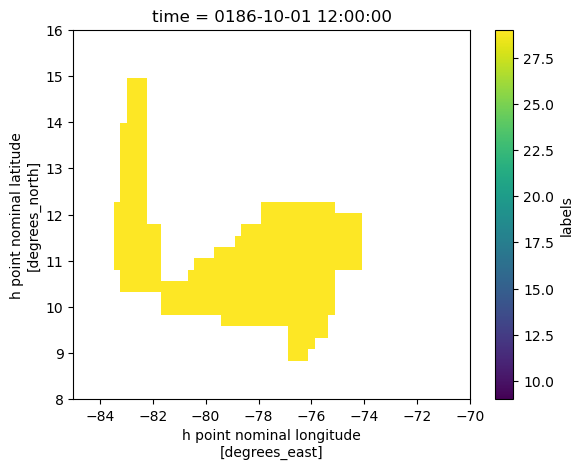

In [13]:
blobs.isel(time=162).plot()
plt.xlim(-85,-70)
plt.ylim(8,16)

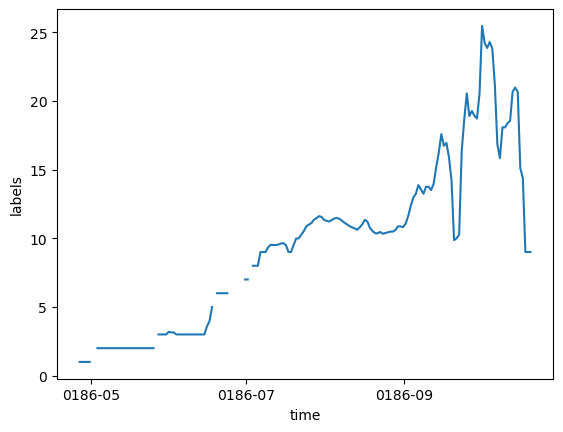

In [14]:
blobs.mean(('xh','yh')).plot()

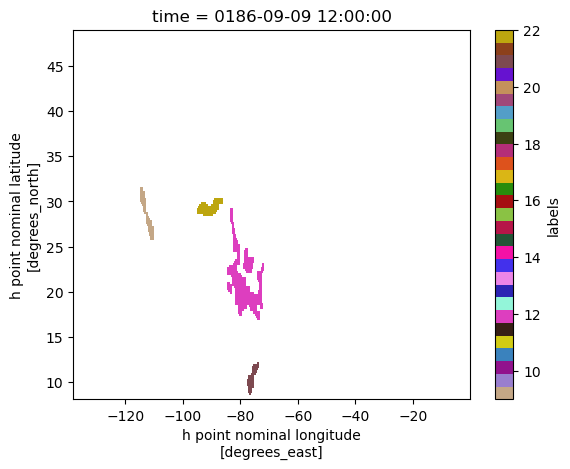

In [343]:
from matplotlib.colors import ListedColormap
maxl = int(np.nanmax(blobs.values))
cm = ListedColormap(np.random.random(size=(maxl, 3)).tolist())

# Make a quick plot of the labeled MHWs identified with Ocetrac
blobs.isel(time=(140)).plot(cmap= cm)

In [15]:
blobs.attrs

{'inital objects identified': 1583,
 'final objects tracked': 29,
 'radius': 2,
 'size quantile threshold': 0.75,
 'min area': 99.0,
 'percent area reject': 0.13257131261084004,
 'percent area accept': 0.8674286873891599}

In [16]:
start = 111
end = 341
binary_out = ds_region['tos'].sel(xh = slice(-138, 0), yh = slice(8, 49)).isel(time = slice(start,end)) > 29
lsmask = xr.ones_like(binary_out.isel(time=0))

In [27]:
# xarray Dataset to save
ds_out = xr.Dataset(
    data_vars=dict(
        blobs=(['time', 'yh', 'xh'], blobs.values, blobs.attrs),
        lsmask=(['yh', 'xh'], lsmask.values),

    ),
    coords=dict(
        xh=tos.xh,
        yh=tos.yh,
        time=tos.time,
    ),
    attrs=dict(description="Ocetrac labels",
               data="CM4.0 preprocessed for Ocetrac",
               threshold='90th percentile',
               climatology='entire period'),
)
ds_out

<xarray.Dataset>
Dimensions:  (time: 230, yh: 193, xh: 547)
Coordinates:
  * xh       (xh) float64 -137.9 -137.7 -137.4 ... -0.7242 -0.4758 -0.2274
  * yh       (yh) float64 8.222 8.469 8.716 8.963 ... 48.43 48.59 48.76 48.92
  * time     (time) object 0186-04-22 12:00:00 ... 0186-12-07 12:00:00
Data variables:
    blobs    (time, yh, xh) float64 nan nan nan nan nan ... nan nan nan nan nan
    lsmask   (yh, xh) bool True True True True True ... True True True True True
Attributes:
    description:  Ocetrac labels
    data:         CM4.0 preprocessed for Ocetrac
    threshold:    90th percentile
    climatology:  entire period

##### ds_out is the xarray dataset to save as an nc file containing ocetrac_labels

In [36]:
ds_out.to_netcdf("/pub/mariant3/VeryWarmWaterMasses/saved_blob_output_ncfiles/ocetrac_labels.nc")

ignore below

In [37]:
labels = ds_out.blobs
num_events = labels.attrs['final objects tracked']
print(f"There are {num_events} total events tracked.")
ds_out

There are 29 total events tracked.


<xarray.Dataset>
Dimensions:  (time: 230, yh: 193, xh: 547)
Coordinates:
  * xh       (xh) float64 -137.9 -137.7 -137.4 ... -0.7242 -0.4758 -0.2274
  * yh       (yh) float64 8.222 8.469 8.716 8.963 ... 48.43 48.59 48.76 48.92
  * time     (time) object 0186-04-22 12:00:00 ... 0186-12-07 12:00:00
Data variables:
    blobs    (time, yh, xh) float64 nan nan nan nan nan ... nan nan nan nan nan
    lsmask   (yh, xh) bool True True True True True ... True True True True True
Attributes:
    description:  Ocetrac labels
    data:         CM4.0 preprocessed for Ocetrac
    threshold:    90th percentile
    climatology:  entire period

In [68]:
labels.xh

<xarray.DataArray 'xh' (xh: 547)>
array([-137.936757, -137.684007, -137.431239, ...,   -0.724151,   -0.475763,
         -0.227385])
Coordinates:
  * xh       (xh) float64 -137.9 -137.7 -137.4 ... -0.7242 -0.4758 -0.2274
Attributes:
    long_name:  h point nominal longitude
    units:      degrees_east
    axis:       X

In [38]:
%%time
labels.load()

CPU times: user 110 µs, sys: 22 µs, total: 132 µs
Wall time: 136 µs


<xarray.DataArray 'blobs' (time: 230, yh: 193, xh: 547)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * xh       (xh) float64 -137.9 -137.7 -137.4 ... -0.7242 -0.4758 -0.2274
  * yh       (yh) float64 8.222 8.469 8.716 8.963 ... 48.43 48.59 48.76 48.92
  * time     (time) object 0186-04-22 12:00:00 ... 0186-12-07 12:00:00
Attributes:
    inital objects identified:  1583
    final objects tracked:      29
    radius:                     2
    size quantile threshold:    0.75
    min area:                   99.0
    percent area reject:        0.13257131261084004
    percent area accept:        0.8674286873891599

In [62]:
ssta = ds_region['tos']

In [63]:
import os, glob
import xarray as xr
import numpy as np
import pandas as pd
import warnings
from skimage.measure import label as label_np
from skimage.measure import regionprops 

try:
    from tqdm.auto import tqdm
    tqdm_avail = True
except:
    warnings.warn(
        "Optional dependency `tqdm` not found. This will make progressbars a lot nicer. \
    Install with `conda install -c conda-forge tqdm`"
    )
    tqdm_avail = False
    
def _wrap(labels):
    ''' Impose periodic boundary and wrap labels, then reorder the labels'''
    first_column = labels[..., 0]
    last_column = labels[..., -1]

    stacked = first_column.stack(z=['time','yh'])
    unique_first = np.unique(stacked[stacked.notnull()])

    # This loop iterates over the unique values in the first column, finds the location of those values in 
    # the first columnm and then uses that index to replace the values in the last column with the first column value
    for i in enumerate(unique_first):
        first = np.where(first_column == i[1])
        last = last_column[first[0], first[1]]
        stacked = last.stack(z=['time','yh'])
        bad_labels = np.unique(stacked[stacked.notnull()])
        replace = np.isin(labels, bad_labels)
        labels = labels.where(replace==False, other=i[1])
    
    labels = labels.fillna(0)
    labels_wrapped = np.unique(labels, return_inverse=True)[1].reshape(labels.shape)
    labels_wrapped = xr.DataArray(labels_wrapped, dims=labels.dims, coords=labels.coords)

    return labels_wrapped

def _get_labels(binary_images):
    '''function used to label binary images at each time step using skimage.measure.label'''
    blobs_labels = label_np(binary_images, background=0)
    return blobs_labels
    
def _get_centroids(sub_labels):
    '''This function uses skimage.measure.regionprops to find the centroids of objects assigned 
    to each unique label'''
    props = regionprops(sub_labels.astype('int'))
    centroids = [(float(sub_labels.yh[round(p.centroid[0])].values),
                  float(sub_labels.xh[round(p.centroid[1])].values)) for p in props]
    for i in range(0,len(centroids)):
        if centroids[i][1] >= 359.875:
            centroids[i] = (centroids[i][0], list(centroids[i])[1] - 359.875)
    
    return centroids

def _get_intensity_area(event, ssta, mhw):
    '''Calculates event intensities and area at each time interval using anomaly data and coordinates 
    cooresponding to the event.'''
    
    event_ssta = ssta.where(event>0, drop=True)
    mhw['intensity_mean'].append(event_ssta.mean(('yh','xh')).values)
    mhw['intensity_max'].append(event_ssta.max(('yh','xh')).values) 
    mhw['intensity_min'].append(event_ssta.min(('yh','xh')).values)
    mhw['intensity_cumulative'].append(np.nansum(event_ssta))
    coords = event.stack(z=('yh','xh'))
    coord_pairs = [(coords.isel(time=t[0]).dropna(dim='z', how='any').z.yh.values, 
                      coords.isel(time=t[0]).dropna(dim='z', how='any').z.xh.values) for t in enumerate(event.time)]

    mhw['coords'].append(coord_pairs)

    # Calculate weighted cell area assuming 0.25º resolution data and 111 km per degree of latitude
    y, x = zip(*coord_pairs)
    dlon = [np.cos(y[c]*np.pi/180)*(111*.25) for c in np.arange(0, len(coord_pairs))]
    dlat = (111*.25) * np.ones(len(dlon))
    cell_area = [np.sum(dlon[c]*dlat[c]) for c in np.arange(0, len(coord_pairs))]
    mhw['area'].append(cell_area)

    return mhw

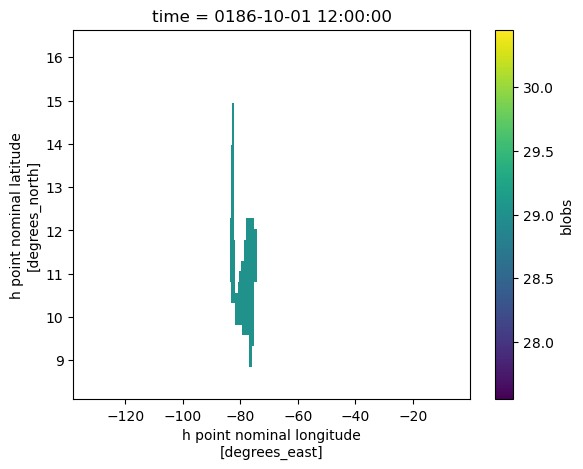

In [139]:
event.isel(time=0).plot()

In [133]:
event_ssta = ssta.where(event>0, drop=True)

(8.0, 16.0)

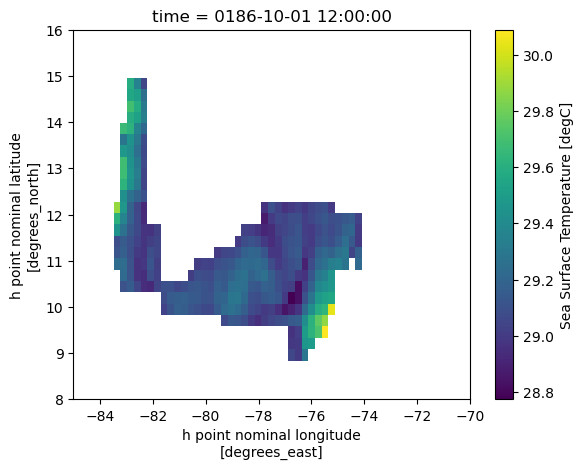

In [168]:
event_ssta.isel(time=0).plot()
plt.xlim(-85,-70)
plt.ylim(8,16)

In [17]:
def _get_metrics(event, ssta):
    '''
    Creates a Pandas DataFrame of event attributes.
    
    Parameters
    ----------
      event : xarray.DataArray   
              Image set containing only objects corresponding to the event of interest. 
              Dimensions should be ('time', 'lat', 'lon')
              
      ssta  : xarray.DataArray
              Temperature vector [1D numpy array of length T]
    
    Returns
    -------
    
    mhw : pandas.DataFrame
          Marine heat wave event attributes. The keys listed below are 
          are contained within the dataset.
 
        'id'                     Unique label given to the MHW [int]
        'date'                   Dates corresponding to the event [datetime format]
        'coords'                 Latitude and longitude of all points contained in the event [tuple(lat,lon)]
        'centroid'               Center of each object contained in the event [tuple(lat,lon)]
        'duration'               Duration of event [months]
        'intensity_max'          Maximum intensity at each time interval [degC]
        'intensity_mean'         Mean intensity at each time interval [degC]
        'intensity_min'          Minimum intensity at each time interval [degC]
        'intensity_cumulative'   Cumulated intensity over the entire event [degC months]
        'area'                   Area of the event at each time interval [km2]
        
    '''
    
    # Initialize dictionary 
    mhw = {}
    mhw['id'] = [] # event label
    mhw['date'] = [] # datetime format
    mhw['coords'] = [] # (lat, lon)
    mhw['centroid'] = []  # (lat, lon)
    mhw['duration'] = [] # [months]
    mhw['intensity_max'] = [] # [deg C]
    mhw['intensity_mean'] = [] # [deg C]
    mhw['intensity_min'] = [] # [deg C]
    mhw['intensity_cumulative'] = [] # [deg C]
    mhw['area'] = [] # [km2]

    # TO ADD:
    # mhw['rate_onset'] = [] # [deg C / month]
    # mhw['rate_decline'] = [] # [deg C / month]

    mhw['id'].append(int(np.nanmedian(event.values)))
    mhw['date'].append(event.time.values.astype('datetime64[M]'))
    mhw['duration'].append(event.time.shape[0])

    # Turn images into binary
    binary_event = event.where(event>=0, other=0)
    binary_event = binary_event.where(binary_event==0, other=1)
      
    sub_labels = xr.apply_ufunc(_get_labels, binary_event,
                                input_core_dims=[['yh', 'xh']],
                                output_core_dims=[['yh', 'xh']],
                                output_dtypes=[binary_event.dtype],
                                vectorize=True,
                                dask='parallelized')
    
    # Turn background to NaNs
    sub_labels = xr.DataArray(sub_labels, dims=binary_event.dims, coords=binary_event.coords)
    sub_labels = sub_labels.where(sub_labels>0, drop=False, other=np.nan) 

    # The labels are repeated each time step, therefore we relabel them to be consecutive
    for p in range(1, sub_labels.shape[0]):
        sub_labels[p,:,:] = sub_labels[p,:,:].values + sub_labels[p-1,:,:].max().values
    
    sub_labels_wrapped = _wrap(sub_labels)
    
    mhw = _get_intensity_area(event, ssta, mhw)
    
 # '  centroid = []
 #   for s in np.arange(0, sub_labels_wrapped.shape[0]):
 #       lx = sub_labels_wrapped.isel(time=s)
 #       east = lx.where(lx.xh < 180, drop=True)
 #       east['xh'] = labels.xh
 #       append_east = xr.concat([lx.where(lx.xh >= 180, drop=True), east], dim="xh")
#        centroid.append(_get_centroids(append_east))
#    mhw['centroid'].append(centroid)'
    
    mhw = pd.DataFrame(dict([(name, pd.Series(data)) for name,data in mhw.items()]))
#     mhw.to_csv('df_'+str(mhw['id'].values[0]).zfill(4)+'.csv', index=False)
    return mhw


In [73]:
dataframes = []  
for i in range(1,num_events+1):
    print(i)
    event = labels.where(labels==i, drop=True).reindex({"xh": labels.xh.values})
    df = _get_metrics(event, ssta)
    dataframes.append(df)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [102]:
dff = pd.concat(dataframes, ignore_index=True)

In [124]:
dff

id                                               date  \
0    1      [0186-04, 0186-04, 0186-04, 0186-04, 0186-04]   
1    2  [0186-05, 0186-05, 0186-05, 0186-05, 0186-05, ...   
2    3  [0186-05, 0186-05, 0186-05, 0186-05, 0186-05, ...   
3    4                        [0186-05, 0186-06, 0186-06]   
4    5                        [0186-06, 0186-06, 0186-06]   
5    6      [0186-06, 0186-06, 0186-06, 0186-06, 0186-06]   
6    7                                 [0186-06, 0186-07]   
7    8                        [0186-07, 0186-07, 0186-07]   
8    9  [0186-07, 0186-07, 0186-07, 0186-07, 0186-07, ...   
9   10  [0186-07, 0186-07, 0186-07, 0186-07, 0186-07, ...   
10  11                                 [0186-07, 0186-07]   
11  12  [0186-07, 0186-07, 0186-07, 0186-07, 0186-07, ...   
12  13                                 [0186-07, 0186-07]   
13  14  [0186-08, 0186-08, 0186-08, 0186-08, 0186-08, ...   
14  15               [0186-08, 0186-08, 0186-08, 0186-08]   
15  16                                          [0186-08]   
16  17  [0186-09, 0186-09, 0186-09, 0186-09, 0186-09, ...   
17  18                                 [0186-09, 0186-09]   
18  19                                          [0186-09]   
19  20                                 [0186-09, 0186-09]   
20  21               [0186-09, 0186-09, 0186-09, 0186-09]   
21  22  [0186-09, 0186-09, 0186-09, 0186-09, 0186-09, ...   
22  23                                          [0186-09]   
23  24                                 [0186-09, 0186-09]   
24  25               [0186-09, 0186-09, 0186-09, 0186-09]   
25  26  [0186-09, 0186-09, 0186-09, 0186-09, 0186-09, ...   
26  27                        [0186-09, 0186-09, 0186-09]   
27  28  [0186-09, 0186-10, 0186-10, 0186-10, 0186-10, ...   
28  29  [0186-10, 0186-10, 0186-10, 0186-10, 0186-10, ...   

                                               coords centroid  duration  \
0   [([14.589726512825457, 14.589726512825457, 14....      NaN         5   
1   [([14.589726512825457, 14.589726512825457, 14....      NaN        23   
2   [([12.157724627851596, 12.157724627851596, 12....      NaN        21   
3   [([8.71618532806131, 8.71618532806131, 8.71618...      NaN         3   
4   [([19.84112685293801, 19.84112685293801, 19.84...      NaN         3   
5   [([21.478515716891593, 21.478515716891593, 21....      NaN         5   
6   [([23.32746053066586, 23.32746053066586, 23.32...      NaN         2   
7   [([12.402004520119256, 12.402004520119256, 12....      NaN         3   
8   [([21.24569168928477, 21.24569168928477, 21.24...      NaN       107   
9   [([25.151030584884086, 25.151030584884086, 25....      NaN         8   
10  [([14.589726512825457, 14.589726512825457, 14....      NaN         2   
11  [([25.37711795656977, 25.37711795656977, 25.37...      NaN        65   
12  [([27.835621888656906, 27.835621888656906, 27....      NaN         2   
13  [([23.556825884968063, 23.556825884968063, 23....      NaN         9   
14  [([26.94775340244958, 26.94775340244958, 26.94...      NaN         4   
15  [([13.133454529050514, 13.133454529050514, 13....      NaN         1   
16  [([11.423554500044743, 11.423554500044743, 11....      NaN         6   
17  [([18.424027604366728, 18.424027604366728, 18....      NaN         2   
18  [([21.24569168928477, 21.24569168928477, 21.24...      NaN         1   
19  [([21.478515716891593, 21.478515716891593, 21....      NaN         2   
20  [([8.71618532806131, 8.71618532806131, 8.71618...      NaN         4   
21  [([28.716284451647844, 28.716284451647844, 28....      NaN        12   
22  [([10.195760139144719, 10.195760139144719, 10....      NaN         1   
23  [([8.963215662388485, 8.963215662388485, 8.963...      NaN         2   
24  [([28.716284451647844, 28.716284451647844, 28....      NaN         4   
25  [([15.314327640023597, 15.314327640023597, 15....      NaN        12   
26  [([19.134097231275476, 19.134097231275476, 19....      NaN         3   
27  [([8.468991599524765, 8.468991599524765, 

<Axes: >

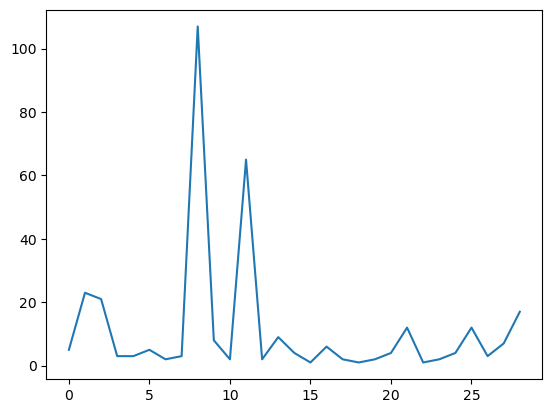

In [94]:
dff['duration'].plot()

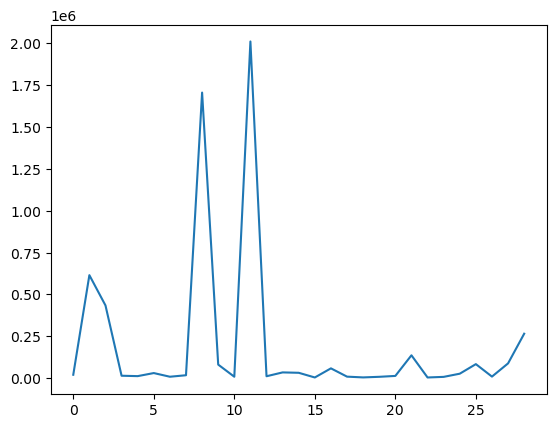

In [86]:
dff['intensity_cumulative'].plot()
plt.show()

In [109]:
num_events

29

In [125]:
dff.to_csv(f"{mt_path}/ocetrac_metrics.csv", index=False)